# 📋 **Modélisation des Notes Clients**

## 🎯 Objectif :  
Prédire les notes clients à partir des avis textuels en utilisant des modèles de machine learning classiques.  
Cette phase comprend : la préparation des données, le traitement du texte, le rééquilibrage des classes, l’entraînement, l’évaluation et l’optimisation des modèles.

---

## 🗂️ **Plan du Notebook**

### I. 🗃️ Importation des Packages  
1. [Chargement et description des librairies essentielles](#1-importation-des-packages)
   
### II. 📥 Chargement et Exploration des Données  
2. [Chargement du dataset](#2-chargement-du-dataset)  
3. [Nettoyage rapide des données manquantes](#3-nettoyage-des-données-manquantes)  
4. [Analyse de la distribution des notes](#4-analyse-de-la-distribution-des-notes)

### III. 🧹 Préparation des Données  
5. [Séparation du jeu en train et test avec stratification](#5-separation-train-test)  
6. [Vectorisation TF-IDF avec suppression des stopwords](#6-vectorisation-tfidf)

### IV. 🔄 Rééquilibrage des Classes  
7. [Application de SMOTE sur le jeu d’entraînement](#7-application-de-smote)

### V. ⚙️ Définition d’une Fonction d’Évaluation des Modèles  
8. [Création d’une fonction d’entraînement et d’évaluation](#8-definition-fonction-evaluation)

### VI. 🚀 Entraînement et Évaluation des Modèles Classiques  
9. [Présentation des modèles sélectionnés](#9-presentation-des-modeles)  
10. [Entraînement, prédiction, et comparaison des performances](#10-entrainement-et-evaluation)

### VII. 📊 Analyse des résultats  
11. [Interprétation des résultats](#11-interpretation-resultats)

### VIII. 💡 Alternatives et améliorations possibles 
12. [Exploration des méthodes pour optimiser les modèles](#12-optimisation)

---


# I. 🗃️ Importation des Packages   

## 1. Chargement et description des librairies essentielles <a name="1-importation-des-packages"></a>

In [1]:
# Librairies pour la manipulation et visualisation des données
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Séparation train/test
from sklearn.model_selection import train_test_split

# Vectorisation TF-IDF du texte
from sklearn.feature_extraction.text import TfidfVectorizer

# Évaluation des modèles (rapport, matrice de confusion, précision)
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Rééquilibrage des classes avec SMOTE & ADASYN
from imblearn.over_sampling import SMOTE
from collections import Counter
from imblearn.over_sampling import SMOTE, ADASYN

# Modèles classiques de machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

# Stopwords français pour le prétraitement textuel
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/laureneattia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# II. 📥 Chargement et Exploration des Données 

## 2. Chargement du dataset <a name="2-chargement-du-dataset"></a>

In [2]:
# Chargement du fichier CSV contenant les avis nettoyés
df = pd.read_csv('reviews_trust_cleaned_imputed.csv')   

# Affichage d’un aperçu des premières lignes pour vérifier le contenu
display(df.head())

,Commentaire,star,commande_weekend,company_ShowRoom,company_VeePee,source_TrustPilot,source_TrustedShop,Commentaire_clean
0,"Bonjour , Ca doit faire 5 ans environ que je s...",1,0,1,0,1,0,bonjour ca doit ans environ membre showroopriv...
1,Vente lacoste article manquant photo prise sur...,1,0,1,0,1,0,vente lacoste article manquant photo prise art...
2,"Vente Lacoste Honteuse , article erroné , arti...",1,0,1,0,1,0,vente lacoste honteuse article erroné article ...
3,J'ai commandé des mules de la marque Moosefiel...,2,0,1,0,1,0,commandé mules marque moosefield très déçue pr...
4,Commande téléphone etat A+ . Livraison d un vi...,1,0,1,0,1,0,téléphone etat vieux téléphone pourri sans bat...


## 3. Nettoyage rapide des données manquantes <a name="3-nettoyage-des-données-manquantes"></a>

In [3]:
# Vérification des valeurs manquantes dans toutes les colonnes
missing_values = df.isna().sum()
print(missing_values)

# Nombre de valeurs manquantes dans la colonne 'Commentaire_clean' avant traitement
missing_before = df['Commentaire_clean'].isna().sum()
print(f"Valeurs manquantes avant traitement : {missing_before}")

# Remplacement des valeurs manquantes dans 'Commentaire_clean' par des chaînes vides
df['Commentaire_clean'] = df['Commentaire_clean'].fillna('')

# Vérification après traitement
missing_after = df['Commentaire_clean'].isna().sum()
print(f"Valeurs manquantes après traitement : {missing_after}")

Commentaire             0
star                    0
commande_weekend        0
company_ShowRoom        0
company_VeePee          0
source_TrustPilot       0
source_TrustedShop      0
Commentaire_clean     169
dtype: int64
Valeurs manquantes avant traitement : 169
Valeurs manquantes après traitement : 0


## 4. Analyse de la distribution des notes <a name="4-analyse-de-la-distribution-des-notes"></a>

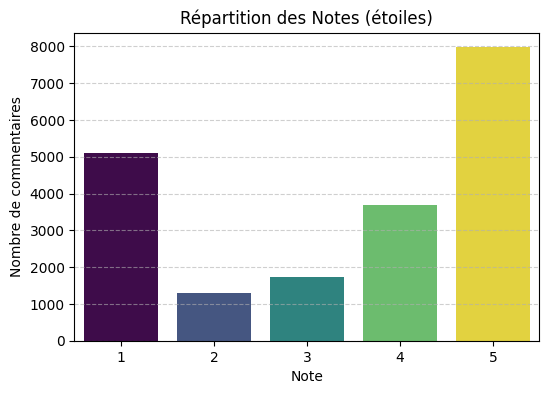

Nombre d'avis par note :
Note 1 : 5109 avis (25.8%)
Note 2 : 1309 avis (6.6%)
Note 3 : 1744 avis (8.8%)
Note 4 : 3700 avis (18.7%)
Note 5 : 7972 avis (40.2%)

Observations :
- Les notes 1 et 5 représentent la majorité des avis, tandis que les notes intermédiaires sont moins fréquentes.
- Cette répartition crée un déséquilibre des classes.

Nous devrons donc explorer des techniques adaptées pour gérer ce déséquilibre lors de la modélisation.


In [4]:
# Visualisation de la distribution des notes (étoiles) attribuées
plt.figure(figsize=(6,4))
sns.countplot(x='star', data=df, hue='star', palette='viridis', legend=False)
plt.title("Répartition des Notes (étoiles)")
plt.xlabel("Note")
plt.ylabel("Nombre de commentaires")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

# Résumé chiffré et analyse rapide
total_avis = len(df)
counts = df['star'].value_counts().sort_index()
percentages = counts / total_avis * 100

print("Nombre d'avis par note :")
for note, count in counts.items():
    print(f"Note {note} : {count} avis ({percentages[note]:.1f}%)")

print("\nObservations :")
print("- Les notes 1 et 5 représentent la majorité des avis, tandis que les notes intermédiaires sont moins fréquentes.")
print("- Cette répartition crée un déséquilibre des classes.")
print("\nNous devrons donc explorer des techniques adaptées pour gérer ce déséquilibre lors de la modélisation.")

# III. 🧹 Préparation des Données

## 5. Séparation du jeu en train et test avec stratification <a name="5-separation-train-test"></a>

In [5]:
# Séparation des features (texte) et de la cible (notes)
X = df['Commentaire_clean']
y = df['star']

# Division du dataset en jeu d'entraînement et de test
X_train_text, X_test_text, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

## 6. Vectorisation TF-IDF avec suppression des stopwords <a name="6-vectorisation-tfidf"></a>

In [6]:
# Chargement des stopwords français pour ignorer les mots fréquents peu informatifs
stopwords_fr = stopwords.words('french')

# Initialisation du vectoriseur TF-IDF 
vectorizer = TfidfVectorizer(
    ngram_range=(1, 2),  # Utilisation des unigrams et bigrams pour mieux capter le contexte
    max_features=10000, # Limitation à 10 000 tokens pour optimiser le temps de calcul
    stop_words=stopwords_fr #  Suppression des stopwords pour épurer le texte
)

# Entraînement du vectoriseur sur le texte d'entraînement et transformation en vecteurs numériques
X_train_vect = vectorizer.fit_transform(X_train_text)

# Transformation du texte de test avec le même vocabulaire (mêmes dimensions)
X_test_vect = vectorizer.transform(X_test_text)

# IV. 🔄 Rééquilibrage des Classes¶

## 7. Application de SMOTE sur le jeu d’entraînement <a name="7-application-de-smote"></a>

In [7]:
# Le jeu d'entraînement est déséquilibré : certaines notes (notamment 2, 3 et 4 étoiles)
# sont sous-représentées, ce qui peut nuire à la qualité des prédictions.

# SMOTE (Synthetic Minority Over-sampling Technique) permet de générer des exemples 
# synthétiques pour les classes minoritaires afin d’équilibrer le jeu d’entraînement.


# Application de SMOTE sur le jeu d'entraînement vectorisé
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_vect, y_train)

# Vérification de la distribution des classes avant et après rééquilibrage
print("Distribution avant SMOTE :")
print(pd.Series(y_train).value_counts().sort_index())

print("\nDistribution après SMOTE :")
print(pd.Series(y_train_res).value_counts().sort_index())


Distribution avant SMOTE :
star
1    4087
2    1047
3    1395
4    2960
5    6378
Name: count, dtype: int64

Distribution après SMOTE :
star
1    6378
2    6378
3    6378
4    6378
5    6378
Name: count, dtype: int64


# V. ⚙️ Définition d’une Fonction d’Évaluation des Modèles  

## 8. Création d’une fonction d’entraînement et d’évaluation <a name="8-definition-fonction-evaluation"></a>

In [8]:
def test_model(clf, X_train, y_train, X_test, y_test):
    """
    Entraîne le modèle, prédit sur les données de test, affiche les métriques et la matrice de confusion,
    puis retourne un résumé des métriques principales.
    """
    clf.fit(X_train, y_train)   # Entraîne le modèle 'clf' sur les données d'entraînement
    y_pred = clf.predict(X_test) # Effectue les prédictions sur les données de test
    
    print(f"\n=== Résultats pour {clf.__class__.__name__} ===")    # Affiche le nom du modèle utilisé
    print(classification_report(y_test, y_pred))   # Affiche le rapport complet des métriques (précision, rappel, F1-score, etc.)
    
    # Affiche la matrice de confusion pour visualiser les erreurs de classification
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Matrice de confusion - {clf.__class__.__name__}")
    plt.xlabel("Classe prédite")
    plt.ylabel("Classe réelle")
    plt.show()
    
    # Calcule les métriques principales pour un résumé et une comparaison facile
    accuracy = accuracy_score(y_test, y_pred)   # Précision globale du modèle
    report = classification_report(y_test, y_pred, output_dict=True)  # Rapport des métriques sous forme de dictionnaire
    
    return {  # Retourne un résumé des métriques clés pour comparaison entre modèles
        'Model': clf.__class__.__name__,
        'Accuracy': accuracy,
        'Macro Precision': report['macro avg']['precision'],
        'Macro Recall': report['macro avg']['recall'],
        'Macro F1-score': report['macro avg']['f1-score']
    }


# VI. 🚀 Entraînement et Évaluation des Modèles Classiques  

## 9. Présentation des modèles sélectionnés <a name="9-presentation-des-modeles"></a>

| Modèle                    | Description                                                   
|--------------------------|---------------------------------------------------------------|
| LogisticRegression       | Modèle linéaire simple, rapide, performant avec TF-IDF.       | 
| MultinomialNB            | Naïve Bayes adapté aux données textuelles discrètes, robuste et rapide. | 
| LinearSVC                | SVM linéaire, efficace pour séparer les classes en NLP. |     
| RandomForestClassifier   | Ensemble d'arbres de décision, gère relations complexes.   |     
| GradientBoostingClassifier | Boosting d’arbres, performant mais plus lent.         |         
| KNeighborsClassifier     | Basé sur la distance, simple, baseline, moins efficace en haute dimension. | 



## 10. Entraînement, prédiction, et comparaison des performances <a name="10-entrainement-et-evaluation"></a>


=== Résultats pour LogisticRegression ===
              precision    recall  f1-score   support

           1       0.82      0.84      0.83      1022
           2       0.21      0.32      0.25       262
           3       0.25      0.35      0.29       349
           4       0.38      0.32      0.35       740
           5       0.80      0.71      0.75      1594

    accuracy                           0.61      3967
   macro avg       0.49      0.51      0.49      3967
weighted avg       0.64      0.61      0.62      3967



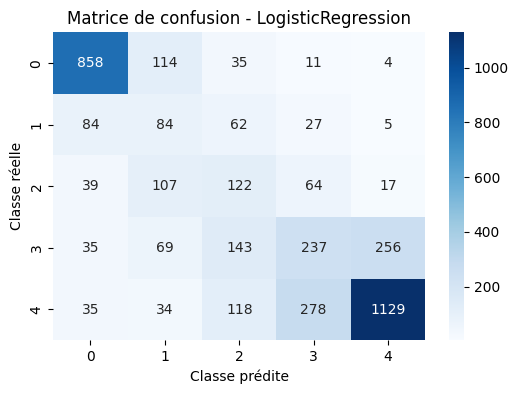


=== Résultats pour MultinomialNB ===
              precision    recall  f1-score   support

           1       0.74      0.83      0.78      1022
           2       0.19      0.31      0.23       262
           3       0.31      0.34      0.32       349
           4       0.40      0.27      0.32       740
           5       0.79      0.75      0.77      1594

    accuracy                           0.62      3967
   macro avg       0.49      0.50      0.49      3967
weighted avg       0.62      0.62      0.61      3967



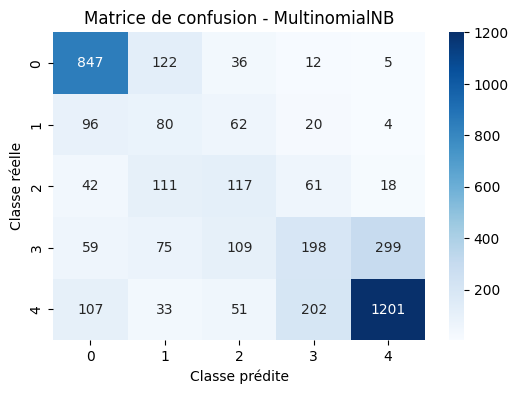


=== Résultats pour LinearSVC ===
              precision    recall  f1-score   support

           1       0.81      0.83      0.82      1022
           2       0.21      0.28      0.24       262
           3       0.24      0.31      0.27       349
           4       0.37      0.31      0.33       740
           5       0.78      0.73      0.76      1594

    accuracy                           0.61      3967
   macro avg       0.48      0.49      0.48      3967
weighted avg       0.63      0.61      0.62      3967



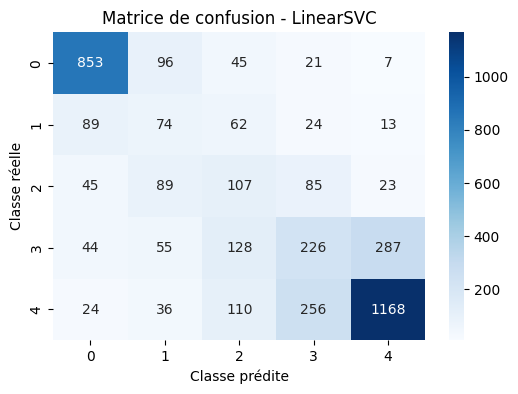


=== Résultats pour RandomForestClassifier ===
              precision    recall  f1-score   support

           1       0.77      0.90      0.83      1022
           2       0.25      0.10      0.14       262
           3       0.30      0.30      0.30       349
           4       0.38      0.34      0.36       740
           5       0.76      0.78      0.77      1594

    accuracy                           0.64      3967
   macro avg       0.49      0.48      0.48      3967
weighted avg       0.62      0.64      0.63      3967



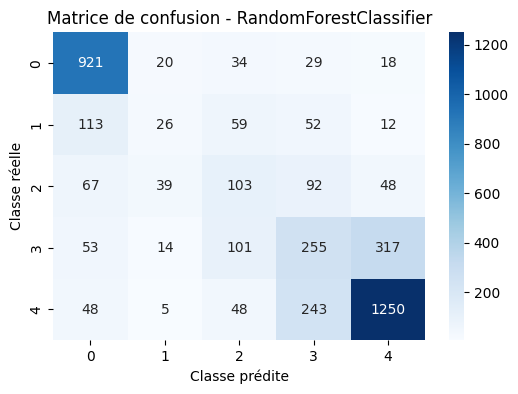


=== Résultats pour GradientBoostingClassifier ===
              precision    recall  f1-score   support

           1       0.83      0.78      0.80      1022
           2       0.19      0.20      0.20       262
           3       0.24      0.28      0.25       349
           4       0.30      0.40      0.35       740
           5       0.76      0.64      0.70      1594

    accuracy                           0.57      3967
   macro avg       0.46      0.46      0.46      3967
weighted avg       0.61      0.57      0.59      3967



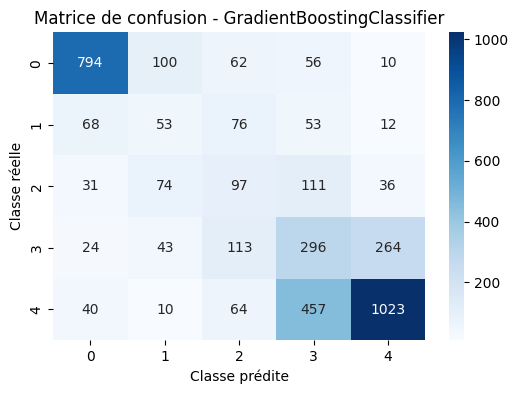


=== Résultats pour KNeighborsClassifier ===
              precision    recall  f1-score   support

           1       0.80      0.44      0.57      1022
           2       0.14      0.27      0.19       262
           3       0.15      0.51      0.23       349
           4       0.26      0.30      0.27       740
           5       0.81      0.46      0.58      1594

    accuracy                           0.41      3967
   macro avg       0.43      0.39      0.37      3967
weighted avg       0.60      0.41      0.47      3967



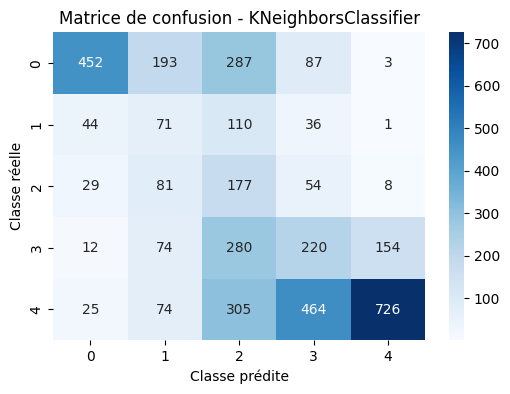


=== Comparatif des modèles ===
                        Model  Accuracy  Macro Precision  Macro Recall  \
0          LogisticRegression  0.612554         0.492135      0.507653   
1               MultinomialNB  0.615831         0.485208      0.498074   
2                   LinearSVC  0.612049         0.481134      0.492365   
3      RandomForestClassifier  0.644064         0.490936      0.484865   
4  GradientBoostingClassifier  0.570456         0.463841      0.459783   
5        KNeighborsClassifier  0.414923         0.434085      0.394636   

   Macro F1-score  
0        0.494715  
1        0.485565  
2        0.484038  
3        0.480087  
4        0.458935  
5        0.370487  


In [10]:
models = [
    LogisticRegression(max_iter=1000, random_state=42),
    MultinomialNB(),
    LinearSVC(random_state=42, max_iter=10000),
    RandomForestClassifier(n_estimators=100, random_state=42),
    GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42),
    KNeighborsClassifier(n_neighbors=5)
]


# Pour chaque modèle, on entraîne, prédit et enregistre les métriques clés

results = []
for model in models:
    res = test_model(model, X_train_res, y_train_res, X_test_vect, y_test)
    results.append(res)

# Création d'un tableau comparatif trié par F1-score macro (moyenne sur toutes les classes)
df_results = pd.DataFrame(results)
df_results = df_results.sort_values(by='Macro F1-score', ascending=False).reset_index(drop=True)

print("\n=== Comparatif des modèles ===")
print(df_results)


# VII. 📊 Analyse des résultats  

## 11. Interprétation des résultats <a name="11-interpretation-resultats"></a>


- **Meilleurs modèles :** LogisticRegression, MultinomialNB et RandomForest (~61% précision globale).  
- **Bonnes prédictions :** Classes extrêmes (1 & 5 étoiles) avec F1-score ~0.7-0.8.  
- **Difficultés :** Classes intermédiaires (2, 3, 4 étoiles) faibles (F1 ~0.25-0.35), dues au déséquilibre des classes. 
- **Rééquilibrage :** SMOTE améliore, mais ne suffit pas totalement.  
- **Améliorations possibles :** Utiliser des modèles à base d’**embeddings puissants** (ex : BERT) ou stratégies ciblées pour traiter les classes minoritaires.


# VIII. 💡 Alternatives et améliorations possibles 

## 12. Exploration des méthodes pour optimiser les modèles <a name="12-optimisation"></a>

- **GridSearchCV**  
  Permet d'optimiser les hyperparamètres des modèles (ex : `C` pour LogisticRegression, `n_estimators` pour RandomForest) afin d'améliorer leurs performances.

- **Avantages de GridSearchCV**  
  - Évite le choix arbitraire des paramètres  
  - Améliore la généralisation du modèle  
  - Peut aider à mieux gérer les classes difficiles

- **À combiner avec**  
  - SMOTE pour équilibrer les classes minoritaires  
  - Modèles basés sur des embeddings puissants (ex : BERT) pour un meilleur encodage du texte



In [ ]:
# ----------------- TESTS METHODE ADASYN --------------------#

In [59]:
# Import de la méthode ADASYN
from imblearn.over_sampling import ADASYN

# Application d'ADASYN sur le jeu d'entraînement vectorisé
adasyn = ADASYN(random_state=42, n_neighbors=3)
X_train_res_ada, y_train_res_ada = adasyn.fit_resample(X_train_vect, y_train)

# Vérification de la distribution des classes avant et après rééquilibrage
print("Distribution avant ADASYN :")
print(pd.Series(y_train).value_counts().sort_index())

print("\nDistribution après ADASYN :")
print(pd.Series(y_train_res_ada).value_counts().sort_index())

Distribution avant ADASYN :
star
1    4087
2    1047
3    1395
4    2960
5    6378
Name: count, dtype: int64

Distribution après ADASYN :
star
1    7363
2    6141
3    6485
4    7052
5    6378
Name: count, dtype: int64



=== Résultats pour LogisticRegression ===
              precision    recall  f1-score   support

           1       0.80      0.85      0.83      1022
           2       0.21      0.29      0.24       262
           3       0.26      0.35      0.30       349
           4       0.40      0.38      0.39       740
           5       0.81      0.69      0.74      1594

    accuracy                           0.62      3967
   macro avg       0.50      0.51      0.50      3967
weighted avg       0.64      0.62      0.63      3967



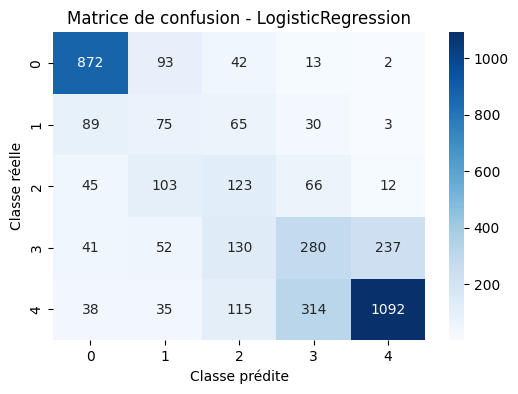


=== Résultats pour MultinomialNB ===
              precision    recall  f1-score   support

           1       0.72      0.85      0.78      1022
           2       0.21      0.24      0.22       262
           3       0.32      0.35      0.33       349
           4       0.39      0.32      0.35       740
           5       0.79      0.72      0.75      1594

    accuracy                           0.61      3967
   macro avg       0.48      0.50      0.49      3967
weighted avg       0.62      0.61      0.61      3967



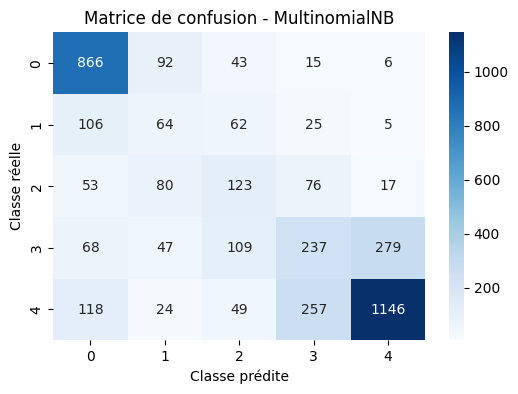


=== Résultats pour LinearSVC ===
              precision    recall  f1-score   support

           1       0.80      0.85      0.82      1022
           2       0.21      0.26      0.23       262
           3       0.25      0.32      0.28       349
           4       0.37      0.34      0.36       740
           5       0.79      0.71      0.75      1594

    accuracy                           0.61      3967
   macro avg       0.48      0.50      0.49      3967
weighted avg       0.63      0.61      0.62      3967



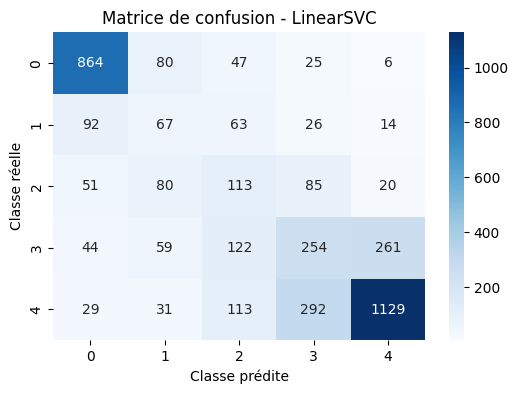


=== Résultats pour RandomForestClassifier ===
              precision    recall  f1-score   support

           1       0.75      0.91      0.82      1022
           2       0.25      0.10      0.14       262
           3       0.29      0.28      0.28       349
           4       0.36      0.34      0.35       740
           5       0.76      0.76      0.76      1594

    accuracy                           0.64      3967
   macro avg       0.48      0.48      0.47      3967
weighted avg       0.61      0.64      0.62      3967



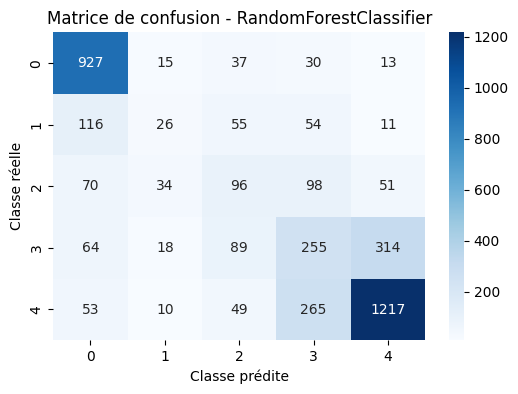


=== Résultats pour GradientBoostingClassifier ===
              precision    recall  f1-score   support

           1       0.82      0.79      0.81      1022
           2       0.19      0.16      0.17       262
           3       0.24      0.26      0.25       349
           4       0.31      0.47      0.37       740
           5       0.77      0.61      0.68      1594

    accuracy                           0.57      3967
   macro avg       0.47      0.46      0.46      3967
weighted avg       0.61      0.57      0.58      3967



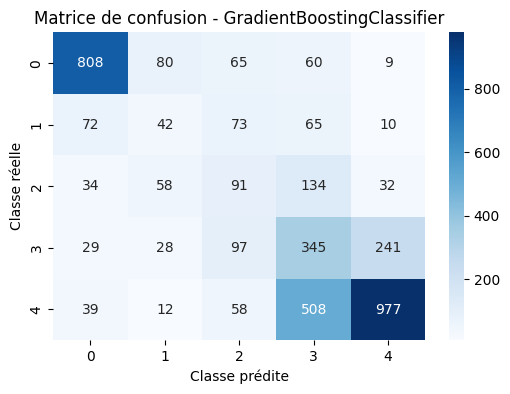


=== Résultats pour KNeighborsClassifier ===
              precision    recall  f1-score   support

           1       0.82      0.48      0.61      1022
           2       0.12      0.30      0.18       262
           3       0.16      0.46      0.24       349
           4       0.26      0.32      0.29       740
           5       0.81      0.41      0.55      1594

    accuracy                           0.41      3967
   macro avg       0.43      0.40      0.37      3967
weighted avg       0.61      0.41      0.46      3967



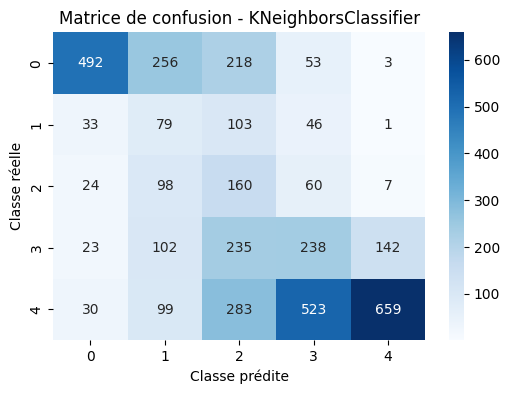


=== Comparatif des modèles avec ADASYN ===
                        Model  Accuracy  Macro Precision  Macro Recall  \
0          LogisticRegression  0.615579         0.496343      0.511074   
1               MultinomialNB  0.614066         0.483894      0.496657   
2                   LinearSVC  0.611797         0.484005      0.495287   
3      RandomForestClassifier  0.635493         0.484319      0.477887   
4  GradientBoostingClassifier  0.570456         0.466170      0.458159   
5        KNeighborsClassifier  0.410386         0.434463      0.395287   

   Macro F1-score  
0        0.499827  
1        0.487723  
2        0.487499  
3        0.472896  
4        0.456805  
5        0.370837  


In [60]:
# Évaluation des modèles avec les données rééquilibrées par ADASYN
results_adasyn = []
for model in models:
    res = test_model(model, X_train_res_ada, y_train_res_ada, X_test_vect, y_test)
    results_adasyn.append(res)

# Comparaison des résultats
df_results_adasyn = pd.DataFrame(results_adasyn)
df_results_adasyn = df_results_adasyn.sort_values(by='Macro F1-score', ascending=False).reset_index(drop=True)

print("\n=== Comparatif des modèles avec ADASYN ===")
print(df_results_adasyn)

In [61]:
# Ajout d'une colonne pour indiquer la méthode de rééquilibrage
df_results['Rééquilibrage'] = 'SMOTE'
df_results_adasyn['Rééquilibrage'] = 'ADASYN'

# Fusion des deux tableaux
df_comparatif = pd.concat([df_results, df_results_adasyn], ignore_index=True)

# Affichage du tableau comparatif global
print("\n=== Comparaison globale SMOTE vs ADASYN ===")
print(df_comparatif.sort_values(by=['Model', 'Rééquilibrage']))



=== Comparaison globale SMOTE vs ADASYN ===
                         Model  Accuracy  Macro Precision  Macro Recall  \
34  GradientBoostingClassifier  0.570456         0.466170      0.458159   
13  GradientBoostingClassifier  0.568370         0.486817      0.480758   
14  GradientBoostingClassifier  0.568370         0.486817      0.480758   
22  GradientBoostingClassifier  0.570456         0.463841      0.459783   
23  GradientBoostingClassifier  0.570456         0.463841      0.459783   
24  GradientBoostingClassifier  0.570456         0.463841      0.459783   
35        KNeighborsClassifier  0.410386         0.434463      0.395287   
25        KNeighborsClassifier  0.414923         0.434085      0.394636   
26        KNeighborsClassifier  0.414923         0.434085      0.394636   
27        KNeighborsClassifier  0.414923         0.434085      0.394636   
28        KNeighborsClassifier  0.346846         0.422962      0.351311   
29        KNeighborsClassifier  0.346846         0.4229

In [ ]:
#➡️ ADASYN est légèrement meilleur pour les modèles linéaires (LogisticRegression, LinearSVC)
#➡️ SMOTE est meilleur sur les modèles basés sur des arbres et Naïve Bayes

Distribution des classes après regroupement (train) :
star
1    4087
2    2442
3    9338
Name: count, dtype: int64

Distribution des classes après regroupement (test) :
star
1    1022
2     611
3    2334
Name: count, dtype: int64

=== Résultats pour LogisticRegression ===
              precision    recall  f1-score   support

           1       0.79      0.86      0.82      1022
           2       0.45      0.63      0.53       611
           3       0.95      0.81      0.88      2334

    accuracy                           0.80      3967
   macro avg       0.73      0.77      0.74      3967
weighted avg       0.83      0.80      0.81      3967



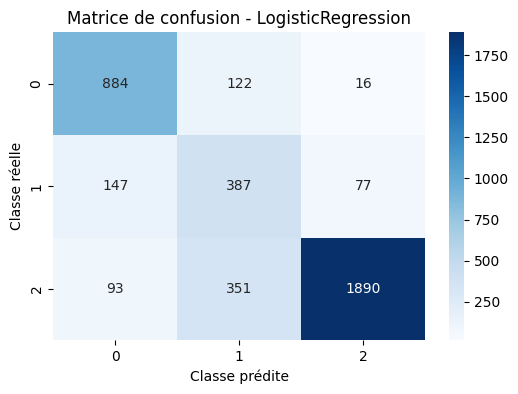


=== Résultats pour MultinomialNB ===
              precision    recall  f1-score   support

           1       0.73      0.86      0.79      1022
           2       0.47      0.64      0.54       611
           3       0.96      0.80      0.87      2334

    accuracy                           0.79      3967
   macro avg       0.72      0.77      0.73      3967
weighted avg       0.83      0.79      0.80      3967



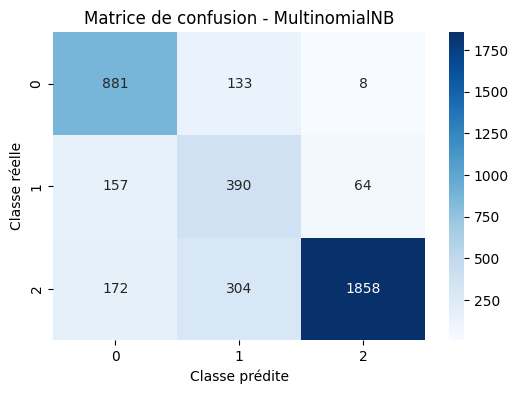


=== Résultats pour LinearSVC ===
              precision    recall  f1-score   support

           1       0.78      0.86      0.82      1022
           2       0.43      0.55      0.48       611
           3       0.94      0.82      0.88      2334

    accuracy                           0.79      3967
   macro avg       0.71      0.74      0.73      3967
weighted avg       0.82      0.79      0.80      3967



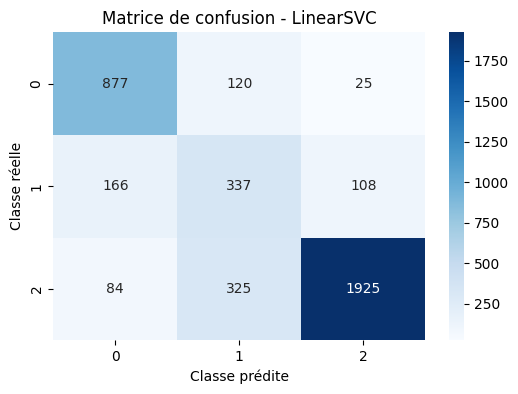


=== Résultats pour RandomForestClassifier ===
              precision    recall  f1-score   support

           1       0.80      0.87      0.83      1022
           2       0.49      0.53      0.51       611
           3       0.92      0.87      0.89      2334

    accuracy                           0.82      3967
   macro avg       0.74      0.75      0.74      3967
weighted avg       0.82      0.82      0.82      3967



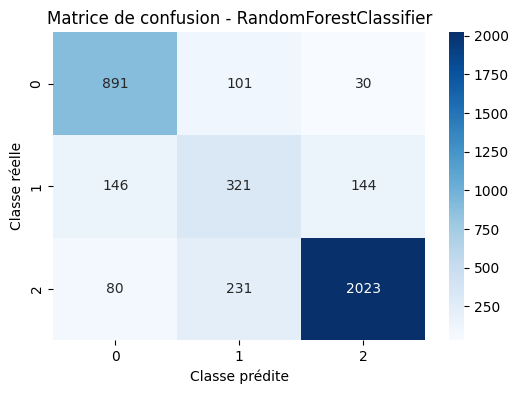


=== Résultats pour GradientBoostingClassifier ===
              precision    recall  f1-score   support

           1       0.83      0.78      0.81      1022
           2       0.33      0.69      0.45       611
           3       0.93      0.69      0.80      2334

    accuracy                           0.72      3967
   macro avg       0.70      0.72      0.68      3967
weighted avg       0.81      0.72      0.75      3967



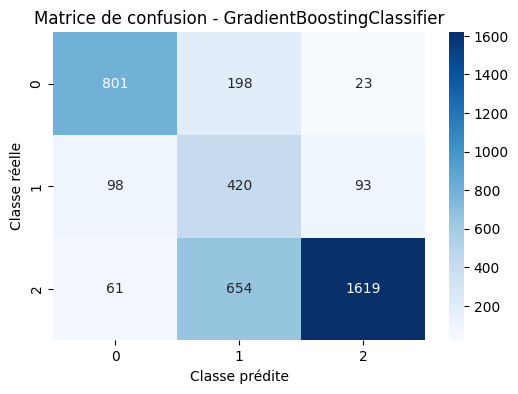


=== Résultats pour KNeighborsClassifier ===
              precision    recall  f1-score   support

           1       0.72      0.58      0.64      1022
           2       0.26      0.79      0.39       611
           3       0.98      0.54      0.70      2334

    accuracy                           0.59      3967
   macro avg       0.65      0.64      0.58      3967
weighted avg       0.80      0.59      0.63      3967



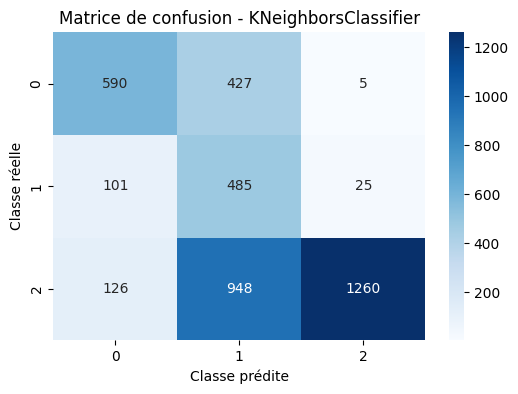


=== Résultats avec regroupement de classes ===
                        Model  Accuracy  Macro Precision  Macro Recall  \
0      RandomForestClassifier  0.815478         0.736684      0.754647   
1          LogisticRegression  0.796824         0.729859      0.769376   
2               MultinomialNB  0.788757         0.720793      0.765464   
3                   LinearSVC  0.791278         0.714831      0.744814   
4  GradientBoostingClassifier  0.715906         0.699235      0.721605   
5        KNeighborsClassifier  0.588606         0.653217      0.636975   

   Macro F1-score         Rééquilibrage  
0        0.744657  SMOTE + regroupement  
1        0.741880  SMOTE + regroupement  
2        0.734443  SMOTE + regroupement  
3        0.725545  SMOTE + regroupement  
4        0.683381  SMOTE + regroupement  
5        0.576524  SMOTE + regroupement  

Observations :
- L'ajout du regroupement de classes et du rééchantillonnage SMOTE améliore nettement les performances.
- RandomForest atte

In [13]:
# IX. 🔁 Regroupement de Classes (1, 2&3, 4&5)
# Nouveau mapping des classes
mapping = {
    1: 1,
    2: 2,
    3: 2,
    4: 3,
    5: 3
}

# Application du mapping
y_train_grouped = y_train.map(mapping)
y_test_grouped = y_test.map(mapping)

# Affichage des nouvelles répartitions
print("Distribution des classes après regroupement (train) :")
print(y_train_grouped.value_counts().sort_index())

print("\nDistribution des classes après regroupement (test) :")
print(y_test_grouped.value_counts().sort_index())

# Rééquilibrage avec SMOTE ou ADASYN sur les classes regroupées
smote_grouped = SMOTE(random_state=42)
X_train_res_grouped, y_train_res_grouped = smote_grouped.fit_resample(X_train_vect, y_train_grouped)

# Évaluation des modèles sur les nouvelles classes
results_grouped = []
for model in models:
    res = test_model(model, X_train_res_grouped, y_train_res_grouped, X_test_vect, y_test_grouped)
    results_grouped.append(res)

# Résumé
df_results_grouped = pd.DataFrame(results_grouped)
df_results_grouped['Rééquilibrage'] = 'SMOTE + regroupement'
df_results_grouped = df_results_grouped.sort_values(by='Macro F1-score', ascending=False).reset_index(drop=True)

print("\n=== Résultats avec regroupement de classes ===")
print(df_results_grouped)

print("\nObservations :")
print("- L'ajout du regroupement de classes et du rééchantillonnage SMOTE améliore nettement les performances.")
print("- RandomForest atteint la meilleure performance globale (81.5% de précision, 74.5% de F1-macro).")
print("- Les modèles linéaires (LogisticRegression, MultinomialNB) bénéficient également fortement de ce prétraitement.")
print("- Le GradientBoosting progresse significativement, signe que la qualité des données était limitante initialement.")
print("- Le KNN reste moins performant malgré une amélioration.")

print("\nConclusion :")
print("- L'approche 'SMOTE + regroupement' est pertinente pour ce jeu déséquilibré.")
print("- Une validation croisée et une analyse détaillée par classe sont recommandées pour confirmer ces résultats.")



Lancement RandomizedSearchCV pour LogisticRegression...
Meilleurs paramètres LogisticRegression : {'tfidf__ngram_range': (1, 1), 'tfidf__max_df': 1.0, 'clf__C': 10}
Meilleur F1-macro LogisticRegression : 0.6820

Lancement RandomizedSearchCV pour LinearSVC...
Meilleurs paramètres LinearSVC : {'tfidf__ngram_range': (1, 1), 'tfidf__max_df': 0.9, 'clf__max_iter': 10000, 'clf__C': 1}
Meilleur F1-macro LinearSVC : 0.6745

Lancement RandomizedSearchCV pour RandomForest...
Meilleurs paramètres RandomForest : {'tfidf__ngram_range': (1, 1), 'tfidf__max_df': 0.9, 'clf__n_estimators': 50, 'clf__min_samples_split': 2, 'clf__max_depth': None}
Meilleur F1-macro RandomForest : 0.6051

Évaluation sur le test complet :

=== Résultats pour Pipeline ===
              precision    recall  f1-score   support

           1       0.82      0.83      0.83      1022
           2       0.51      0.43      0.47       611
           3       0.89      0.92      0.91      2334

    accuracy                         

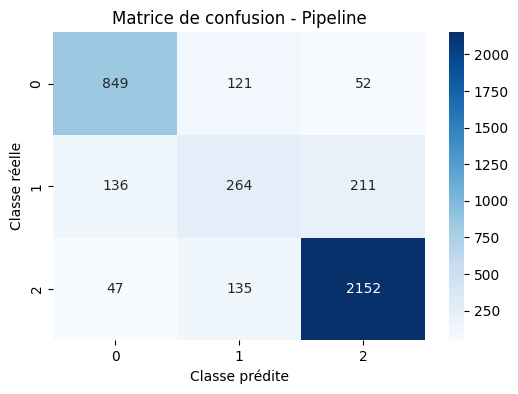


=== Résultats pour Pipeline ===
              precision    recall  f1-score   support

           1       0.82      0.85      0.84      1022
           2       0.50      0.36      0.42       611
           3       0.88      0.93      0.90      2334

    accuracy                           0.82      3967
   macro avg       0.73      0.71      0.72      3967
weighted avg       0.81      0.82      0.81      3967



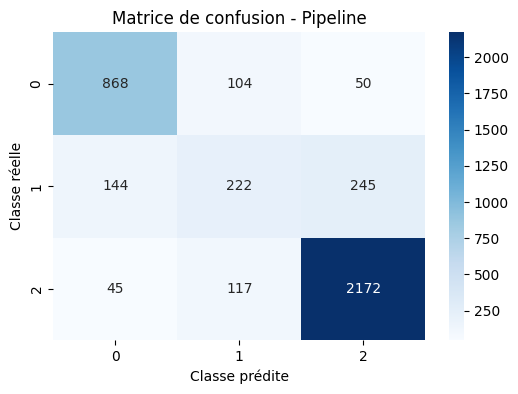


=== Résultats pour Pipeline ===
              precision    recall  f1-score   support

           1       0.78      0.89      0.83      1022
           2       0.58      0.24      0.33       611
           3       0.85      0.93      0.89      2334

    accuracy                           0.81      3967
   macro avg       0.73      0.68      0.68      3967
weighted avg       0.79      0.81      0.79      3967



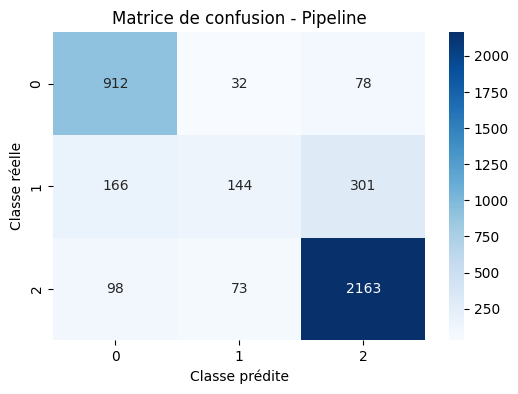

In [ ]:
# METHODE GRID SEARCH

from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# Sous-échantillon rapide pour GridSearch (20% du train)
X_train_sample, _, y_train_sample, _ = train_test_split(
    X_train_text, y_train_grouped, test_size=0.8, random_state=42, stratify=y_train_grouped)

stopwords_fr = stopwords.words('french')

# Grilles légères pour chaque modèle

param_dist_logreg = {
    'tfidf__max_df': [0.9, 1.0],
    'tfidf__ngram_range': [(1,1), (1,2)],
    'clf__C': [0.1, 1, 10]
}

param_dist_svc = {
    'tfidf__max_df': [0.9, 1.0],
    'tfidf__ngram_range': [(1,1), (1,2)],
    'clf__C': [0.1, 1, 10],
    'clf__max_iter': [10000]
}

param_dist_rf = {
    'tfidf__max_df': [0.9, 1.0],
    'tfidf__ngram_range': [(1,1)],
    'clf__n_estimators': [50, 100],
    'clf__max_depth': [None, 10],
    'clf__min_samples_split': [2, 5]
}

# Pipelines

pipeline_logreg = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stopwords_fr, max_features=5000)),
    ('clf', LogisticRegression(random_state=42, max_iter=1000))
])

pipeline_svc = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stopwords_fr, max_features=5000)),
    ('clf', LinearSVC(random_state=42))
])

pipeline_rf = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stopwords_fr, max_features=5000)),
    ('clf', RandomForestClassifier(random_state=42))
])

# Fonction pour lancer la recherche aléatoire

def run_random_search(pipeline, param_dist, X_train, y_train, model_name):
    print(f"\nLancement RandomizedSearchCV pour {model_name}...")
    random_search = RandomizedSearchCV(
        pipeline, param_dist, n_iter=10, cv=3, scoring='f1_macro', n_jobs=-1, random_state=42)
    random_search.fit(X_train, y_train)
    print(f"Meilleurs paramètres {model_name} : {random_search.best_params_}")
    print(f"Meilleur F1-macro {model_name} : {random_search.best_score_:.4f}")
    return random_search.best_estimator_

# Exécution

best_logreg = run_random_search(pipeline_logreg, param_dist_logreg, X_train_sample, y_train_sample, "LogisticRegression")
best_svc = run_random_search(pipeline_svc, param_dist_svc, X_train_sample, y_train_sample, "LinearSVC")
best_rf = run_random_search(pipeline_rf, param_dist_rf, X_train_sample, y_train_sample, "RandomForest")

# Évaluation finale sur le jeu de test complet

print("\nÉvaluation sur le test complet :")
for model in [best_logreg, best_svc, best_rf]:
    test_model(model, X_train_text, y_train_grouped, X_test_text, y_test_grouped)


In [ ]:
print("\n=== Résultats avec Grid Search (sans rééquilibrage) ===")
print("F1-macro LogisticRegression : 0.6820")
print("F1-macro LinearSVC : 0.6745")
print("F1-macro RandomForest : 0.6051")

print("\nObservations :")
print("- L'optimisation par Grid Search améliore les hyperparamètres mais ne compense pas le déséquilibre des classes.")
print("- L'accuracy reste comparable (~82%), mais le F1-macro est plus faible, indiquant un compromis entre précision et rappel.")
print("- La classe minoritaire (classe 2) est particulièrement difficile à prédire, avec un rappel faible dans tous les modèles.")

print("\nConclusion :")
print("- Le rééquilibrage via SMOTE combiné au regroupement de classes reste nécessaire pour de meilleures performances.")
print("- Il serait intéressant de combiner Grid Search et SMOTE pour optimiser à la fois les paramètres et l'équilibre des classes.")



=== Résultats avec Grid Search (sans rééquilibrage) ===
F1-macro LogisticRegression : 0.6820
F1-macro LinearSVC : 0.6745
F1-macro RandomForest : 0.6051

Observations :
- L'optimisation par Grid Search améliore les hyperparamètres mais ne compense pas le déséquilibre des classes.
- L'accuracy reste comparable (~82%), mais le F1-macro est plus faible, indiquant un compromis entre précision et rappel.
- La classe minoritaire (classe 2) est particulièrement difficile à prédire, avec un rappel faible dans tous les modèles.

Conclusion :
- Le rééquilibrage via SMOTE combiné au regroupement de classes reste nécessaire pour de meilleures performances.
- Il serait intéressant de combiner Grid Search et SMOTE pour optimiser à la fois les paramètres et l'équilibre des classes.


100%|████████████████████████████████████| 19834/19834 [01:08<00:00, 291.35it/s]



=== Résultats pour LogisticRegression ===
              precision    recall  f1-score   support

           1       0.79      0.87      0.83      1022
           2       0.45      0.63      0.53       611
           3       0.95      0.81      0.88      2334

    accuracy                           0.80      3967
   macro avg       0.73      0.77      0.74      3967
weighted avg       0.83      0.80      0.81      3967



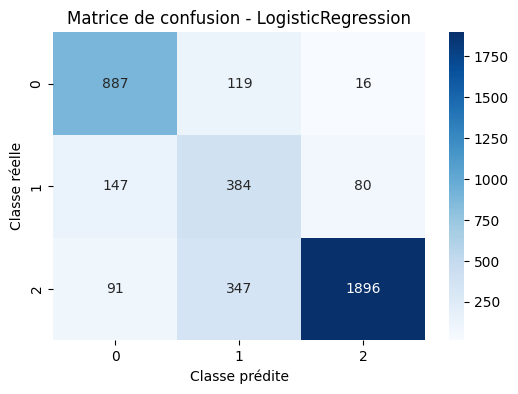


=== Résultats pour MultinomialNB ===
              precision    recall  f1-score   support

           1       0.73      0.86      0.79      1022
           2       0.47      0.64      0.54       611
           3       0.96      0.80      0.87      2334

    accuracy                           0.79      3967
   macro avg       0.72      0.76      0.73      3967
weighted avg       0.83      0.79      0.80      3967



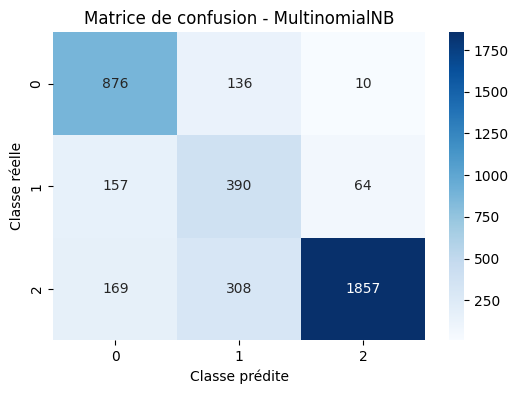


=== Résultats pour LinearSVC ===
              precision    recall  f1-score   support

           1       0.78      0.85      0.81      1022
           2       0.43      0.55      0.48       611
           3       0.93      0.83      0.88      2334

    accuracy                           0.79      3967
   macro avg       0.71      0.74      0.72      3967
weighted avg       0.81      0.79      0.80      3967



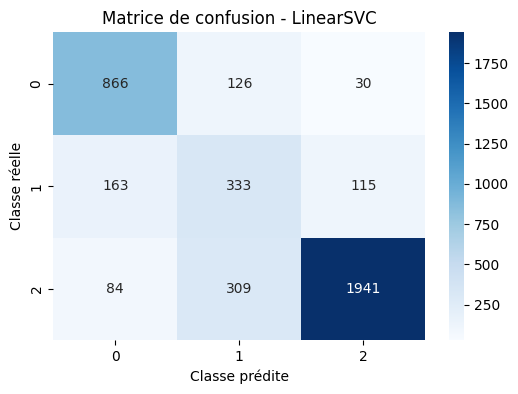


=== Résultats pour RandomForestClassifier ===
              precision    recall  f1-score   support

           1       0.79      0.88      0.83      1022
           2       0.49      0.51      0.50       611
           3       0.92      0.87      0.89      2334

    accuracy                           0.81      3967
   macro avg       0.73      0.75      0.74      3967
weighted avg       0.82      0.81      0.82      3967



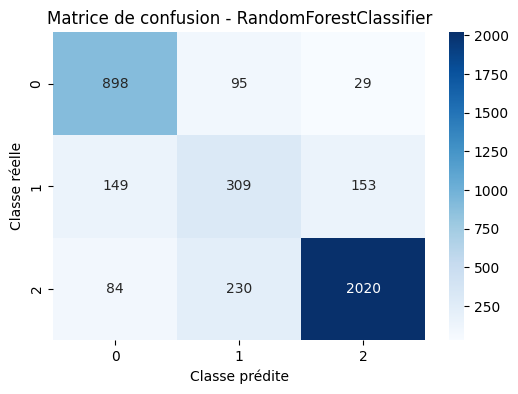


=== Résultats pour GradientBoostingClassifier ===
              precision    recall  f1-score   support

           1       0.83      0.79      0.81      1022
           2       0.33      0.69      0.45       611
           3       0.93      0.70      0.80      2334

    accuracy                           0.72      3967
   macro avg       0.70      0.73      0.69      3967
weighted avg       0.82      0.72      0.75      3967



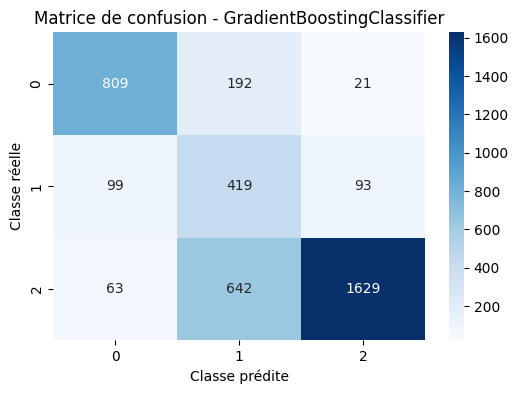


=== Résultats pour KNeighborsClassifier ===
              precision    recall  f1-score   support

           1       0.71      0.60      0.65      1022
           2       0.27      0.80      0.40       611
           3       0.98      0.54      0.69      2334

    accuracy                           0.59      3967
   macro avg       0.65      0.65      0.58      3967
weighted avg       0.80      0.59      0.64      3967



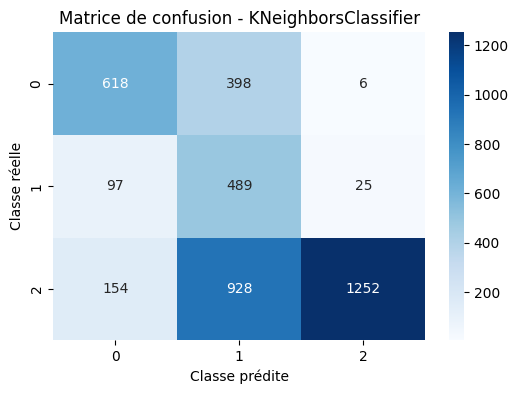


=== Résultats FINAUX avec NER (entités) + regroupement de classes + SMOTE ===
                        Model  Accuracy  Macro Precision  Macro Recall  \
0          LogisticRegression  0.798336         0.730672      0.769574   
3      RandomForestClassifier  0.813461         0.732906      0.749955   
1               MultinomialNB  0.787245         0.719363      0.763690   
2                   LinearSVC  0.791530         0.714053      0.741329   
4  GradientBoostingClassifier  0.720192         0.700718      0.725097   
5        KNeighborsClassifier  0.594656         0.652141      0.647147   

   Macro F1-score  
0        0.742832  
3        0.740408  
1        0.732790  
2        0.724160  
4        0.686843  
5        0.583014  


In [29]:
# METHODE NER + REGROUPEMENT DE CLASSES + SMOTE

import spacy
from tqdm import tqdm

# Chargement du modèle spaCy français
nlp = spacy.load("fr_core_news_md")  # ou 'fr_core_news_sm' si pas de md dispo

# === Étape 0 : Extraction des entités depuis les commentaires ===
def extract_named_entities(text):
    doc = nlp(text)
    return ' '.join([ent.text for ent in doc.ents if ent.label_ not in ['DATE', 'TIME', 'ORDINAL', 'CARDINAL']])

# Application de la NER à tous les commentaires nettoyés
tqdm.pandas()
df['entities_all'] = df['Commentaire_clean'].progress_apply(extract_named_entities)

# === Étape 1 : Fusion du texte nettoyé + entités ===
df['entities_all'] = df['entities_all'].fillna('')
df['commentaire_plus_entities'] = df['Commentaire_clean'] + ' ' + df['entities_all']

# === Étape 2 : Reprise pipeline classique avec texte enrichi ===

# 1. Séparation des features (texte enrichi) et des labels (notes)
X = df['commentaire_plus_entities']
y = df['star']

# 2. Split train/test stratifié
X_train_text, X_test_text, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 3. Vectorisation TF-IDF
vectorizer = TfidfVectorizer(
    ngram_range=(1, 2),
    max_features=10000,
    stop_words=stopwords.words('french')
)
X_train_vect = vectorizer.fit_transform(X_train_text)
X_test_vect = vectorizer.transform(X_test_text)

# 4. SMOTE pour équilibrer les classes
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_vect, y_train)

# 5. Regroupement des classes (1, 2-3, 4-5)
mapping = {1: 1, 2: 2, 3: 2, 4: 3, 5: 3}
y_train_grouped = y_train.map(mapping)
y_test_grouped = y_test.map(mapping)
y_train_res_grouped = pd.Series(y_train_res).map(mapping)

# 6. SMOTE sur les classes regroupées
X_train_res_grouped, y_train_res_grouped = smote.fit_resample(X_train_vect, y_train_grouped)

# 7. Définition des modèles à tester
models = [
    LogisticRegression(max_iter=1000, random_state=42),
    MultinomialNB(),
    LinearSVC(random_state=42, max_iter=10000),
    RandomForestClassifier(n_estimators=100, random_state=42),
    GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42),
    KNeighborsClassifier(n_neighbors=5)
]

# 8. Entraînement & évaluation
results_grouped = []
for model in models:
    res = test_model(model, X_train_res_grouped, y_train_res_grouped, X_test_vect, y_test_grouped)
    results_grouped.append(res)

# 9. Résumé
df_results_grouped = pd.DataFrame(results_grouped).sort_values(by='Macro F1-score', ascending=False)
print("\n=== Résultats FINAUX avec NER (entités) + regroupement de classes + SMOTE ===")
print(df_results_grouped)
